In [8]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import os
import pickle
import numpy as np
import argparse
from random import random

from torch import optim
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.nn import functional as F

from sklearn.utils import shuffle

import numpy as np
import random

import torch
import torch.nn as nn
from torch.autograd import Function
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
def preprocess(au_mfcc_path):
    data = []
    labels = []
    with open(au_mfcc_path, 'rb') as f:
        au_mfcc = pickle.load(f)

    print(len(au_mfcc))

    for key in au_mfcc:
        emotion = key.split('-')[2]
        emotion = int(emotion)-1
        labels.append(emotion)
        data.append(torch.FloatTensor(au_mfcc[key]))

    data = np.array(data)
    labels = np.array(labels)  

    fdata = np.column_stack((data, labels))
    fdata = shuffle(fdata)

    data = fdata[:, :-1]
    labels = fdata[:, -1].astype(int)

    return data, labels

In [10]:
class TransformerModel(nn.Module):  #nn.Moudle 父类    PyTorch 中的神经网络模块基类
    def __init__(self, input_dim, d_model, nhead, dim_feedforward, num_layers, output_dim):
        # input_dim 输入维度 # d_model transformer中的模型维度 #nhead 多头注意力机制中的头数
        #dim_feedforward 前馈网络的隐藏层维度  #num_layers transformer编码器的层数 #output_dim 输出的维度
        
        super(TransformerModel, self).__init__()
        #返回一个代理对象，它会代理到 TransformerModel 的父类（即 nn.Module）
        
        self.embedding = nn.Linear(input_dim, d_model)
        # embedding 嵌入
        # 定义了一个嵌入层，用于将输入数据从 input_dim 维度映射到 d_model 维度
        # d_model 是 Transformer 模型中统一的特征维度，所有子层的输入和输出都保持这个维度
        
        self.pos_encoder = PositionalEncoding(d_model)
        #只是创建了一个 PositionalEncoding 类的实例，并没有直接生成位置编码张量。
        #位置编码张量的生成和应用是在前向传播方法中完成的，只有在实际调用 forward 方法时才会运行相关的计算。

        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.1),
            num_layers
        )
        self.fc = nn.Linear(d_model, output_dim)  #全连接

    def forward(self, src, src_mask=None):
        src = self.embedding(src)      # src输入的源序列（max_length,batch_size,input_dim）  传给嵌入层
        src = self.pos_encoder(src)    # 嵌入层的输出作为输入传给位置编码层 添加位置编码特征 （max_length,batch_size,d_model）
        output = self.transformer(src, src_mask)  # 位置编码层的输出传入transformer编码器
        output = output.mean(dim=0)  # 沿着第一个维度取平均值  （batch_size,d_model）
        output = self.fc(output)     #（batch_size,output_dim）
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        #是创建一个形状为 (max_len, d_model) 的全零张量。这个张量将用于存储位置编码（positional encoding）
        #max_len 最大序列长度
        
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # torch.arange 是 PyTorch 中的一个函数，用于生成一个一维张量，包含从起始值到结束值（不包括结束值）的等间距值。
        # 0 是起始值
        # max_len 是结束值，生成的张量不包括这个值。
        # unsqueeze 是 PyTorch 中的一个方法，用于在张量的指定位置插入一个维度。
        # 1 表示在第 1 个位置（从 0 开始计数）插入一个维度。
        
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        #div_term 并不是位置编码本身，而是用于计算位置编码的一个中间变量。
        #它是一个频率因子，用于生成不同频率的正弦和余弦波，这些波组合起来构成位置编码。
        
        
        pe[:, 0::2] = torch.sin(position * div_term)  # pe是一个二维张量 这边是对 所有行  以及偶数列赋值
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                          #最后的pe(1,max_length,d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]    # x的形状固定为（max_length,batch_size,d_model）
        return x                          # 根据广播机制x + pe 会变成（max_length,batch_size,d_model）

class MultiLayerFusion(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim1, hidden_dim2, output_dim):
        super(MultiLayerFusion, self).__init__()
        self.fc1 = nn.Linear(input_dim1 + input_dim2, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)  # (batch_size, input_dim1 + input_dim2)
        x = self.fc1(x)  # (batch_size, hidden_dim1)
        x = self.relu1(x)
        x = self.fc2(x)  # (batch_size, hidden_dim2)
        x = self.relu2(x)
        x = self.fc3(x)  # (batch_size, output_dim)
        return x


class MMF_TransformerModel(nn.Module):
    def __init__(self):
        super(MMF_TransformerModel, self).__init__()
        # AU 
        self.au_transformer = TransformerModel(
            input_dim=35,
            d_model=64,
            nhead=4,
            dim_feedforward=256,  #  表示前馈神经网络的隐藏层维度是 256，这比 d_model=64 大，可以增加模型的非线性拟合能力。
            num_layers=2,
            output_dim=64
        )
        # MFCC 
        self.mfccs_transformer = TransformerModel(
            input_dim=259,
            d_model=64,
            nhead=4,
            dim_feedforward=256,
            num_layers=2,
            output_dim=64
        )
        # Fusion
        # self.fusion_layer = nn.Linear(128, 8)
        self.fusion_layer = MultiLayerFusion(input_dim1=64, input_dim2=64, hidden_dim1=256,hidden_dim2=128, output_dim=8)


    def forward(self, au, mfccs):
        au_output = self.au_transformer(au)
        mfccs_output = self.mfccs_transformer(mfccs)
        # fused_features = torch.cat((au_output, mfccs_output), dim=1)  # 按照第二个维度拼接 64+64
        # final_output = self.fusion_layer(fused_features)  # 将两个fc层的结果连接起来 (batch_size, 8)
        final_output = self.fusion_layer(au_output, mfccs_output)

        return final_output


In [11]:
def eval_CE(data, labels, batch_size, mode=None, to_print=False):
    assert(mode is not None)

    model.eval()

    y_true, y_pred = [], []
    eval_loss = []

    if mode == "test":
        if to_print:
            model.load_state_dict(torch.load(
                f'C:/Users/yangc/deep_learning group_asg/fusion_model_ce.ckpt'))

    corr = 0
    with torch.no_grad():
        for i in range(0, len(data), batch_size):

            d = data[i:i+batch_size]
            l = labels[i:i+batch_size]
            d = np.expand_dims(d, axis=0)


            au = torch.from_numpy(d[:, :, :35]).float()  
            mfccs = torch.from_numpy(d[:, :, 35:]).float()  

       
            au = au.to(device)
            mfccs = mfccs.to(device)
            y = torch.from_numpy(l).long().to(device)  

            output = model(au, mfccs)

            loss = criterion(output, y)
            eval_loss.append(loss.item())


            preds = output.argmax(dim=1).cpu().numpy()
            y_trues = y.cpu().numpy()

            # 计算准确率
            corr += (preds == y_trues).sum()


    eval_loss = np.mean(eval_loss)
    accuracy = corr / len(labels)

    return eval_loss, accuracy

In [12]:
def eval_FL(data, labels, batch_size, mode=None, to_print=False):
    assert(mode is not None)

    model.eval()

    y_true, y_pred = [], []
    eval_loss = []

    if mode == "test":
        if to_print:
            model.load_state_dict(torch.load(
                f'C:/Users/yangc/deep_learning group_asg/fusion_model_fl.ckpt'))

    corr = 0
    with torch.no_grad():
        for i in range(0, len(data), batch_size):

            d = data[i:i+batch_size]
            l = labels[i:i+batch_size]

            d = np.expand_dims(d, axis=0)

            au = torch.from_numpy(d[:, :, :35]).float() 
            mfccs = torch.from_numpy(d[:, :, 35:]).float()  

            au = au.to(device)
            mfccs = mfccs.to(device)
            y = torch.from_numpy(l).long().to(device) 
            output = model(au, mfccs)

            loss = criterion(output, y)
            eval_loss.append(loss.item())

            preds = output.argmax(dim=1).cpu().numpy()
            y_trues = y.cpu().numpy()

            corr += (preds == y_trues).sum()

    eval_loss = np.mean(eval_loss)
    accuracy = corr / len(labels)

    return eval_loss, accuracy

#                                        Different  loss function

#### loss function : CrossEntropyLoss

In [13]:
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_path = 'C:/Users/yangc/deep_learning group_asg/au_mfcc.pkl'  #load data
    data, labels = preprocess(data_path)                #data:2维numpy   labels：1维numpy
    print('u:', np.unique(labels.astype(int)).size)  #8 lables
    
    total_samples = data.shape[0]
    train_size = int(total_samples * 0.8)
    dev_size = int(total_samples * 0.1)
    test_size = int(total_samples * 0.1)
    
    train_data, train_labels = data[:train_size], labels[:train_size]
    dev_data, dev_labels = data[train_size:train_size+dev_size], labels[train_size:train_size+dev_size]
    test_data, test_labels = data[-test_size:], labels[-test_size:]

    model = MMF_TransformerModel()  #export model
    model = model.to(device)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    batch_size = 64
    n_total = len(train_data)
    best_loss = float('inf')

    CrossEntropyLoss_train_loss_list = []
    CrossEntropyLoss_train_acc_list = []
    CrossEntropyLoss_valid_loss_list = []
    CrossEntropyLoss_valid_acc_list = []

    for e in range(100):
        model.train()
        total_loss = 0
        cnt = 0
        # print(f"=====Epoch {e+1} ======")
        for i in range(0, len(train_data), batch_size):
            data_batch = train_data[i:i+batch_size]
            label_batch = train_labels[i:i+batch_size]

            model.zero_grad()
            data_batch = np.expand_dims(data_batch, axis=0)
            au = torch.from_numpy(data_batch[:, :, :35]).float().to(device)   #张量   [1, batch_size, au_feature_dim]
            mfccs = torch.from_numpy(data_batch[:, :, 35:]).float().to(device)  #  
            y = torch.from_numpy(label_batch).long().to(device)


            optimizer.zero_grad()
            fused_features = model(au, mfccs)  
            loss = criterion(fused_features, y)


            loss.backward()
            optimizer.step()
            

        train_loss, train_acc = eval_CE(train_data, train_labels,batch_size,mode="train")

        valid_loss, valid_acc = eval_CE(dev_data, dev_labels,batch_size,mode="dev")

        CrossEntropyLoss_train_loss_list.append(train_loss)
        CrossEntropyLoss_train_acc_list.append(train_acc)
        CrossEntropyLoss_valid_loss_list.append(valid_loss)
        CrossEntropyLoss_valid_acc_list.append(valid_acc)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), 'C:/Users/yangc/deep_learning group_asg/fusion_model_ce.ckpt')
            torch.save(optimizer.state_dict(), 'C:/Users/yangc/deep_learning group_asg/optim_best_ce.std')
        else:
            model.load_state_dict(torch.load('C:/Users/yangc/deep_learning group_asg/fusion_model_ce.ckpt'))
            optimizer.load_state_dict(torch.load('C:/Users/yangc/deep_learning group_asg/optim_best_ce.std'))

    CrossEntropyLoss_test_loss, CrossEntropyLoss_test_acc = eval_CE(test_data, test_labels,batch_size,mode="test", to_print=True)


C:\Users\yangc\AppData\Local\Temp\ipykernel_38852\891376001.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  au_mfcc = pickle.load(f)


1440
u: 8


### loss function: FocalLoss

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss
            
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_path = 'C:/Users/yangc/deep_learning group_asg/au_mfcc.pkl'
    data, labels = preprocess(data_path)
    print('u:', np.unique(labels.astype(int)).size)  
    
    total_samples = data.shape[0]
    train_size = int(total_samples * 0.8)
    dev_size = int(total_samples * 0.1)
    test_size = int(total_samples * 0.1)
    
    train_data, train_labels = data[:train_size], labels[:train_size]
    dev_data, dev_labels = data[train_size:train_size+dev_size], labels[train_size:train_size+dev_size]
    test_data, test_labels = data[-test_size:], labels[-test_size:]

    model = MMF_TransformerModel()  #export model
    model = model.to(device)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    criterion = FocalLoss()

    batch_size = 64
    n_total = len(train_data)
    best_loss = float('inf')

    FocalLoss_train_loss_list = []
    FocalLoss_train_acc_list = []
    FocalLoss_valid_loss_list = []
    FocalLoss_valid_acc_list = []

    for e in range(100):
        model.train()
        total_loss = 0
        cnt = 0
        # print(f"=====Epoch {e+1} ======")
        for i in range(0, len(train_data), batch_size):
            data_batch = train_data[i:i+batch_size]
            label_batch = train_labels[i:i+batch_size]

            model.zero_grad()
            data_batch = np.expand_dims(data_batch, axis=0)
            au = torch.from_numpy(data_batch[:, :, :35]).float().to(device)   #张量   [1, batch_size, au_feature_dim]
            mfccs = torch.from_numpy(data_batch[:, :, 35:]).float().to(device)  #  
            y = torch.from_numpy(label_batch).long().to(device)

       
            optimizer.zero_grad()
            fused_features = model(au, mfccs)  
            loss = criterion(fused_features, y)

            loss.backward()
            optimizer.step()
            
        train_loss, train_acc = eval_FL(train_data, train_labels,batch_size,mode="train")
        
        valid_loss, valid_acc = eval_FL(dev_data, dev_labels,batch_size,mode="dev")

        FocalLoss_train_loss_list.append(train_loss)
        FocalLoss_train_acc_list.append(train_acc)
        FocalLoss_valid_loss_list.append(valid_loss)
        FocalLoss_valid_acc_list.append(valid_acc)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), 'C:/Users/yangc/deep_learning group_asg/fusion_model_fl.ckpt')
            torch.save(optimizer.state_dict(), 'C:/Users/yangc/deep_learning group_asg/optim_best_fl.std')
        else:
            model.load_state_dict(torch.load('C:/Users/yangc/deep_learning group_asg/fusion_model_fl.ckpt'))
            optimizer.load_state_dict(torch.load('C:/Users/yangc/deep_learning group_asg/optim_best_fl.std'))

    # 测试集评估
    FocalLoss_test_loss, FocalLoss_test_acc = eval_FL(test_data, test_labels,batch_size,mode="test", to_print=True)


C:\Users\yangc\AppData\Local\Temp\ipykernel_38852\891376001.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  au_mfcc = pickle.load(f)
C:\Users\yangc\.conda\envs\yolov1\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


1440
u: 8


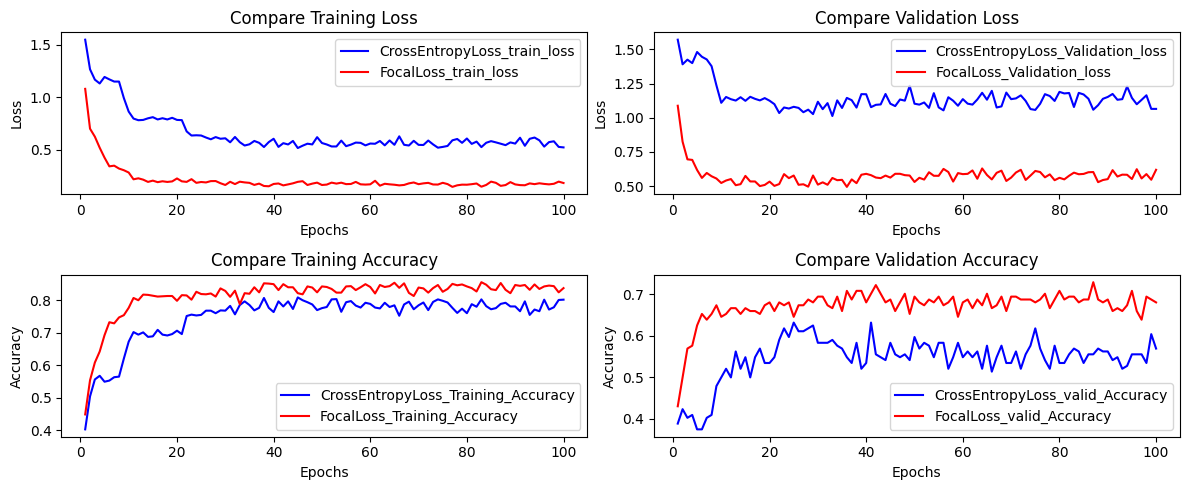

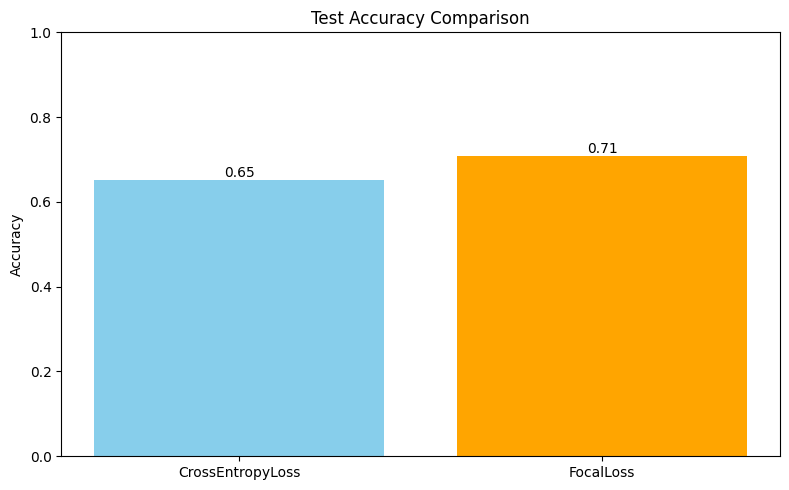

In [15]:
    epochs = range(1, 101)
    plt.figure(figsize=(12, 5))

    # train loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, CrossEntropyLoss_train_loss_list, 'b', label='CrossEntropyLoss_train_loss')
    plt.plot(epochs, FocalLoss_train_loss_list, 'r', label='FocalLoss_train_loss')
    plt.title('Compare Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    #valid loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, CrossEntropyLoss_valid_loss_list, 'b', label='CrossEntropyLoss_Validation_loss')
    plt.plot(epochs, FocalLoss_valid_loss_list, 'r', label='FocalLoss_Validation_loss')
    plt.title('Compare Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 
    plt.subplot(2, 2, 3)
    plt.plot(epochs, CrossEntropyLoss_train_acc_list, 'b', label='CrossEntropyLoss_Training_Accuracy')
    plt.plot(epochs, FocalLoss_train_acc_list, 'r', label='FocalLoss_Training_Accuracy')
    plt.title('Compare Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, CrossEntropyLoss_valid_acc_list, 'b', label='CrossEntropyLoss_valid_Accuracy')
    plt.plot(epochs, FocalLoss_valid_acc_list, 'r', label='FocalLoss_valid_Accuracy')
    plt.title('Compare Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()


    methods = ['CrossEntropyLoss', 'FocalLoss']
    accuracies = [CrossEntropyLoss_test_acc, FocalLoss_test_acc]
    
    # 创建图形
    plt.figure(figsize=(8, 5))
    
    # 绘制柱状图
    bars = plt.bar(methods, accuracies, color=['skyblue', 'orange'])
    
    # 添加数据标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')
    
    # 设置标题和坐标轴标签
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)  # Accuracy 范围在 0 到 1 之间
    
    # 调整布局
    plt.tight_layout()
    
    # 显示图形
    plt.show()
    

# different scales of learning rate

In [9]:
def eval(data, labels, batch_size, mode=None,lr=False,to_print=False):
    assert(mode is not None)

    model.eval()

    y_true, y_pred = [], []
    eval_loss = []

    if mode == "test":
        if to_print and lr is not None:
            lr_str = f"{lr:.0e}".replace('-0', '-')  # 处理科学计数法格式
            model.load_state_dict(torch.load(
                f'C:/Users/yangc/deep_learning group_asg/fusion_model_{lr_str}.ckpt'))

    corr = 0
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            d = data[i:i+batch_size]
            l = labels[i:i+batch_size]

            d = np.expand_dims(d, axis=0)

            au = torch.from_numpy(d[:, :, :35]).float()  
            mfccs = torch.from_numpy(d[:, :, 35:]).float()  

            au = au.to(device)
            mfccs = mfccs.to(device)
            y = torch.from_numpy(l).long().to(device) 

            output = model(au, mfccs)

            loss = criterion(output, y)
            eval_loss.append(loss.item())

            preds = output.argmax(dim=1).cpu().numpy()
            y_trues = y.cpu().numpy()

            corr += (preds == y_trues).sum()

    eval_loss = np.mean(eval_loss)
    accuracy = corr / len(labels)

    return eval_loss, accuracy

In [10]:
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in learning_rates:
    lr_str = f"{lr:.0e}".replace('-0', '-')  # 确保格式正确
    print(f"Learning rate: {lr_str}")


Learning rate: 1e-1
Learning rate: 1e-2
Learning rate: 1e-3
Learning rate: 1e-4
Learning rate: 1e-5


In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss
            
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_path = 'C:/Users/yangc/deep_learning group_asg/au_mfcc.pkl'
    data, labels = preprocess(data_path)
    print('u:', np.unique(labels.astype(int)).size)  
    
    total_samples = data.shape[0]
    train_size = int(total_samples * 0.8)
    dev_size = int(total_samples * 0.1)
    test_size = int(total_samples * 0.1)
    
    train_data, train_labels = data[:train_size], labels[:train_size]
    dev_data, dev_labels = data[train_size:train_size+dev_size], labels[train_size:train_size+dev_size]
    test_data, test_labels = data[-test_size:], labels[-test_size:]

    learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    for lr in learning_rates:

        model = MMF_TransformerModel().to(device)  #export model
    
        lr_str = f"{lr:.0e}".replace('-0', '-')
        best_model_path = f'C:/Users/yangc/deep_learning group_asg/fusion_model_{lr_str}.ckpt'
        best_optim_path = f'C:/Users/yangc/deep_learning group_asg/optim_{lr_str}.std'
        
        # 初始化优化器（使用当前学习率）
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = FocalLoss()
        
        best_loss = float('inf')
    
        batch_size = 64
        n_total = len(train_data)
        best_loss = float('inf')
    
        # train_loss_list = []
        # train_acc_list = []
        # valid_loss_list = []
        # valid_acc_list = []
        
        for e in range(100):
            model.train()
            total_loss = 0
            cnt = 0
            # print(f"=====Epoch {e+1} ======")
            for i in range(0, len(train_data), batch_size):
                data_batch = train_data[i:i+batch_size]
                label_batch = train_labels[i:i+batch_size]
    
                model.zero_grad()
                data_batch = np.expand_dims(data_batch, axis=0)
                au = torch.from_numpy(data_batch[:, :, :35]).float().to(device)   #张量   [1, batch_size, au_feature_dim]
                mfccs = torch.from_numpy(data_batch[:, :, 35:]).float().to(device)  #  
                y = torch.from_numpy(label_batch).long().to(device)
    
           
                optimizer.zero_grad()
                fused_features = model(au, mfccs)  
                loss = criterion(fused_features, y)
    
                loss.backward()
                optimizer.step()
                
            train_loss, train_acc = eval(train_data, train_labels,batch_size,mode="train")
            
            valid_loss, valid_acc = eval(dev_data, dev_labels,batch_size,mode="dev")
    
            # train_loss_list.append(train_loss)
            # train_acc_list.append(train_acc)
            # valid_loss_list.append(valid_loss)
            # valid_acc_list.append(valid_acc)
            
            if valid_loss < best_loss:
                best_loss = valid_loss
                torch.save(model.state_dict(), best_model_path)
                torch.save(optimizer.state_dict(), best_optim_path)
            else:
                model.load_state_dict(torch.load(best_model_path))
                optimizer.load_state_dict(torch.load(best_optim_path))
        
        # 当前学习率训练完成后进行测试
        test_loss, test_acc = eval(test_data, test_labels, 
                                  batch_size=32, 
                                  mode="test", 
                                  lr=lr, 
                                  to_print=True)
        print(f"Learning Rate: {lr:.0e} | Test Accuracy: {test_acc:.4f}")
        test_acc_list.append(round(test_acc, 4))
        
        print(f"Learning Rate: {lr:.0e} | Train Accuracy: {train_acc:.4f}")
        train_acc_list.append(round(train_acc, 4))
        
        print(f"Learning Rate: {lr:.0e} | Train Loss: {train_loss:.4f}")
        train_loss_list.append(round(train_loss, 4))
    
        # # 测试集评估
        # test_loss, test_acc = eval(test_data, test_labels,batch_size,mode="test", to_print=True)
    


1440
u: 8


C:\Users\yangc\AppData\Local\Temp\ipykernel_15084\137241026.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  au_mfcc = pickle.load(f)


Learning Rate: 1e-01 | Test Accuracy: 0.1667
Learning Rate: 1e-01 | Train Accuracy: 0.0668
Learning Rate: 1e-01 | Train Loss: nan
Learning Rate: 1e-02 | Test Accuracy: 0.5000
Learning Rate: 1e-02 | Train Accuracy: 0.5200
Learning Rate: 1e-02 | Train Loss: 0.8086
Learning Rate: 1e-03 | Test Accuracy: 0.7153
Learning Rate: 1e-03 | Train Accuracy: 0.8333
Learning Rate: 1e-03 | Train Loss: 0.1927
Learning Rate: 1e-04 | Test Accuracy: 0.6597
Learning Rate: 1e-04 | Train Accuracy: 0.8073
Learning Rate: 1e-04 | Train Loss: 0.2583
Learning Rate: 1e-05 | Test Accuracy: 0.5347
Learning Rate: 1e-05 | Train Accuracy: 0.5920
Learning Rate: 1e-05 | Train Loss: 0.7755


In [12]:
print(test_acc_list)

[np.float64(0.1667), np.float64(0.5), np.float64(0.7153), np.float64(0.6597), np.float64(0.5347)]


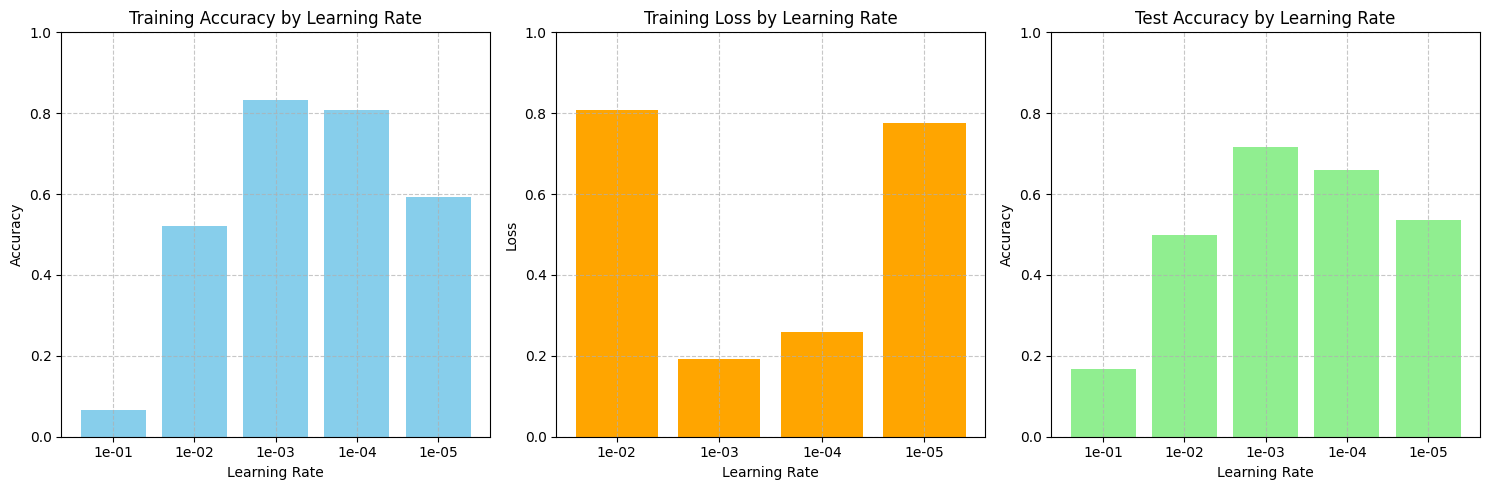

In [13]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar([f"{lr:.0e}" for lr in learning_rates], train_acc_list, color='skyblue')
plt.title('Training Accuracy by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
plt.bar([f"{lr:.0e}" for lr in learning_rates], train_loss_list, color='orange')
plt.title('Training Loss by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.ylim(0, 1.0)  # 确保 y 轴范围在 0 到 1 之间
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
plt.bar([f"{lr:.0e}" for lr in learning_rates], test_acc_list, color='lightgreen')
plt.title('Test Accuracy by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

# Different batch sizes

In [14]:
def eval(data, labels, batch_size, mode=None,lr=False,to_print=False):
    assert(mode is not None)

    model.eval()

    y_true, y_pred = [], []
    eval_loss = []

    if mode == "test":
        if to_print and batch_size is not None:
            model.load_state_dict(torch.load(
                f'C:/Users/yangc/deep_learning group_asg/fusion_model_{batch_size}.ckpt'))

    corr = 0
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            d = data[i:i+batch_size]
            l = labels[i:i+batch_size]

            d = np.expand_dims(d, axis=0)

            au = torch.from_numpy(d[:, :, :35]).float()  
            mfccs = torch.from_numpy(d[:, :, 35:]).float()  

            au = au.to(device)
            mfccs = mfccs.to(device)
            y = torch.from_numpy(l).long().to(device) 

            output = model(au, mfccs)

            loss = criterion(output, y)
            eval_loss.append(loss.item())

            preds = output.argmax(dim=1).cpu().numpy()
            y_trues = y.cpu().numpy()

            corr += (preds == y_trues).sum()

    eval_loss = np.mean(eval_loss)
    accuracy = corr / len(labels)

    return eval_loss, accuracy

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss
            
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_path = 'C:/Users/yangc/deep_learning group_asg/au_mfcc.pkl'
    data, labels = preprocess(data_path)
    print('u:', np.unique(labels.astype(int)).size)  
    
    total_samples = data.shape[0]
    train_size = int(total_samples * 0.8)
    dev_size = int(total_samples * 0.1)
    test_size = int(total_samples * 0.1)
    
    train_data, train_labels = data[:train_size], labels[:train_size]
    dev_data, dev_labels = data[train_size:train_size+dev_size], labels[train_size:train_size+dev_size]
    test_data, test_labels = data[-test_size:], labels[-test_size:]

    batch_sizes= [8, 16, 32, 64, 128]

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    for batch_size in batch_sizes:

        model = MMF_TransformerModel().to(device)  #export model
    
        best_model_path = f'C:/Users/yangc/deep_learning group_asg/fusion_model_{batch_size}.ckpt'
        best_optim_path = f'C:/Users/yangc/deep_learning group_asg/optim_{batch_size}.std'
        
        # 初始化优化器（使用当前学习率）
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = FocalLoss()
        
        best_loss = float('inf')
    
        n_total = len(train_data)
    
        
        for e in range(100):
            model.train()
            total_loss = 0
            cnt = 0
            # print(f"=====Epoch {e+1} ======")
            for i in range(0, len(train_data), batch_size):
                data_batch = train_data[i:i+batch_size]
                label_batch = train_labels[i:i+batch_size]
    
                model.zero_grad()
                data_batch = np.expand_dims(data_batch, axis=0)
                au = torch.from_numpy(data_batch[:, :, :35]).float().to(device)   #张量   [1, batch_size, au_feature_dim]
                mfccs = torch.from_numpy(data_batch[:, :, 35:]).float().to(device)  #  
                y = torch.from_numpy(label_batch).long().to(device)
    
           
                optimizer.zero_grad()
                fused_features = model(au, mfccs)  
                loss = criterion(fused_features, y)
    
                loss.backward()
                optimizer.step()
                
            train_loss, train_acc = eval(train_data, train_labels,batch_size,mode="train")
            
            valid_loss, valid_acc = eval(dev_data, dev_labels,batch_size,mode="dev")
            
            if valid_loss < best_loss:
                best_loss = valid_loss
                torch.save(model.state_dict(), best_model_path)
                torch.save(optimizer.state_dict(), best_optim_path)
            else:
                model.load_state_dict(torch.load(best_model_path))
                optimizer.load_state_dict(torch.load(best_optim_path))
        
        # 当前学习率训练完成后进行测试
        test_loss, test_acc = eval(test_data, test_labels, 
                                  batch_size=batch_size, 
                                  mode="test", 
                                  lr=1e-3, 
                                  to_print=True)
        print(f"Batch Size: {batch_size} | Test Accuracy: {test_acc:.4f}")
        test_acc_list.append(round(test_acc, 4))
        
        print(f"Batch Size: {batch_size} | Train Accuracy: {train_acc:.4f}")
        train_acc_list.append(round(train_acc, 4))
        
        print(f"Batch Size: {batch_size} | Train Loss: {train_loss:.4f}")
        train_loss_list.append(round(train_loss, 4))

C:\Users\yangc\AppData\Local\Temp\ipykernel_15084\137241026.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  au_mfcc = pickle.load(f)


1440
u: 8
Batch Size: 8 | Test Accuracy: 0.6736
Batch Size: 8 | Train Accuracy: 0.7830
Batch Size: 8 | Train Loss: 0.2094
Batch Size: 16 | Test Accuracy: 0.6667
Batch Size: 16 | Train Accuracy: 0.8542
Batch Size: 16 | Train Loss: 0.1467
Batch Size: 32 | Test Accuracy: 0.7361
Batch Size: 32 | Train Accuracy: 0.8281
Batch Size: 32 | Train Loss: 0.1918
Batch Size: 64 | Test Accuracy: 0.6806
Batch Size: 64 | Train Accuracy: 0.8160
Batch Size: 64 | Train Loss: 0.2146
Batch Size: 128 | Test Accuracy: 0.6458
Batch Size: 128 | Train Accuracy: 0.8151
Batch Size: 128 | Train Loss: 0.2144


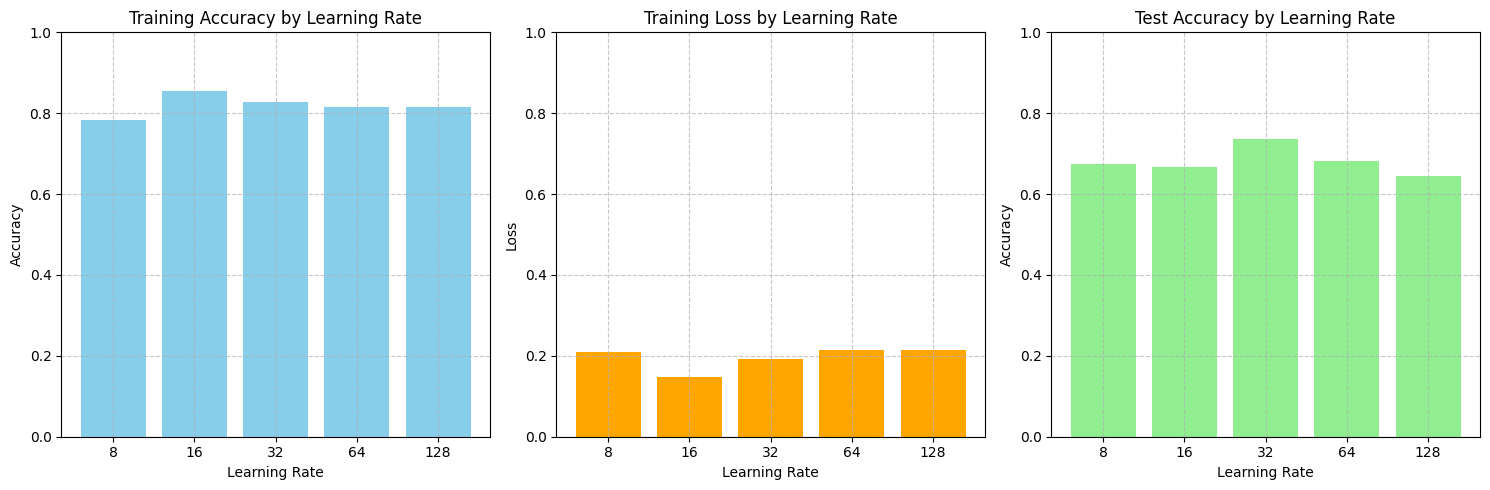

In [16]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar([f"{batch_size}" for batch_size in batch_sizes], train_acc_list, color='skyblue')
plt.title('Training Accuracy by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
plt.bar([f"{batch_size}" for batch_size in batch_sizes], train_loss_list, color='orange')
plt.title('Training Loss by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.ylim(0, 1.0)  
plt.grid(True, linestyle='--', alpha=0.7)

# 绘制测试准确率柱状图
plt.subplot(1, 3, 3)
plt.bar([f"{batch_size}" for batch_size in batch_sizes], test_acc_list, color='lightgreen')
plt.title('Test Accuracy by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.7)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()